In [1]:
import os
import torch
import itertools
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from typing import List, Tuple, Dict
from tqdm import tqdm
import random

In [2]:
# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


* **Getting the train and test dataset**

In [4]:
# Define a classe de transformação
class Transform:
    def __init__(self):
        self.data_transform = transforms.Compose([transforms.ToTensor()])

    def __call__(self, inp):
        return self.data_transform(inp)

# Define a classe SeismicDataset para carregar dados binários
class SeismicDataset:
    def __init__(self, elastic_folder, acoustic_folder, shape=(256, 256, 1)):
        self.elastic_files = sorted([os.path.join(elastic_folder, f) for f in os.listdir(elastic_folder) if f.endswith('.bin')])
        self.acoustic_files = sorted([os.path.join(acoustic_folder, f) for f in os.listdir(acoustic_folder) if f.endswith('.bin')])
        self.transformer = Transform()

        # Define o tamanho dos patches com base no parâmetro `shape`
        self.patch_shape = shape

        # Verifica se o número de patches é o mesmo em ambas as pastas
        assert len(self.elastic_files) == len(self.acoustic_files), "Número de patches deve ser igual em ambas as pastas."

    def __len__(self):
        return len(self.elastic_files)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        # Carrega os patches binários para elastic e acoustic
        elastic_patch = np.fromfile(self.elastic_files[idx], dtype='float32').reshape(self.patch_shape)
        acoustic_patch = np.fromfile(self.acoustic_files[idx], dtype='float32').reshape(self.patch_shape)
        
        # Transforma para tensor
        elastic_patch = self.transformer(elastic_patch)
        acoustic_patch = self.transformer(acoustic_patch)

        return acoustic_patch, elastic_patch


# Define as pastas de treino e teste
train_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\elastic_vx'
train_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\acoustic'
test_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\elastic_vx'
test_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\acoustic'

# Cria o dataset e DataLoader para treino e teste
train_ds = SeismicDataset(train_elastic_path, train_acoustic_path, shape=(256, 256, 1))
test_ds = SeismicDataset(test_elastic_path, test_acoustic_path, shape=(768, 361, 1))

# Parâmetros do DataLoader
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_TEST = 1

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE_TEST, shuffle=False, drop_last=False)

print("DataLoaders de treino e teste criados com sucesso!")

DataLoaders de treino e teste criados com sucesso!


In [5]:
# Número total de patches no dataset de treino
num_train_patches = len(train_ds)
num_test_patches = len(test_ds)

# Número de batches no DataLoader
num_train_batches = len(train_dl)
num_test_batches = len(test_dl)

print(f"Número total de patches de treino: {num_train_patches}")
print(f"Número total de patches de teste: {num_test_patches}")
print(f"Número total de batches de treino: {num_train_batches}")
print(f"Número total de batches de teste: {num_test_batches}")

Número total de patches de treino: 3000
Número total de patches de teste: 61
Número total de batches de treino: 750
Número total de batches de teste: 61


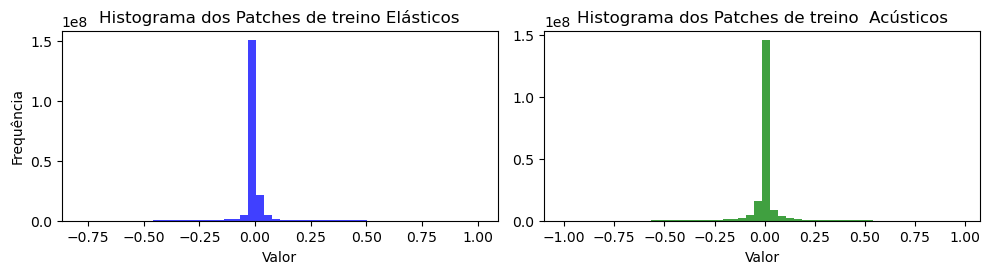

In [6]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in train_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de treino Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de treino  Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

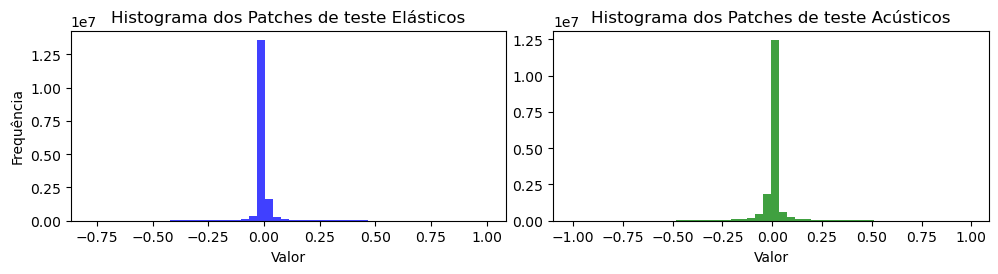

In [7]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in test_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de teste Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de teste Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

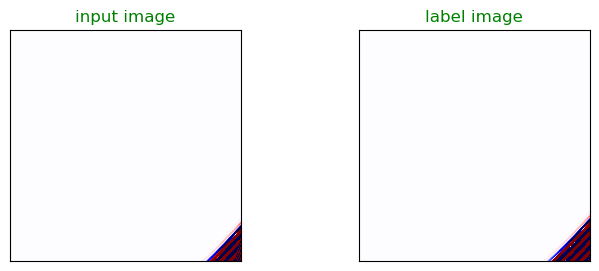

In [8]:
def show_img_sample(train_dl):
    for i, (real_input, real_target) in enumerate(train_dl):
        if i > 0:
            break
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))
        ax = axes.ravel()
        
        perc = 99
        vmax = np.percentile(np.abs(real_input[0].squeeze()), perc)
        vmin = -vmax
        
        ax[0].imshow(real_input[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title("input image", c="g")
        ax[1].imshow(real_target[0].squeeze(), cmap='seismic',vmin=vmin, vmax=vmax)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title("label image", c="g")
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

show_img_sample(train_dl)

* **Define the generator and discriminator**

In [10]:
class GeneratorUnet(nn.Module):
    def __init__(self, in_channels):
        super(GeneratorUnet, self).__init__()
        self.down_stack = nn.ModuleList([
            self.Downsample(in_channels, 64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            self.Downsample(64, 128),  # (batch_size, 64, 64, 128)
            self.Downsample(128, 256),  # (batch_size, 32, 32, 256)
            self.Downsample(256, 512),  # (batch_size, 16, 16, 512)
            self.Downsample(512, 512),  # (batch_size, 8, 8, 512)
            self.Downsample(512, 512),  # (batch_size, 4, 4, 512)
            self.Downsample(512, 512),  # (batch_size, 2, 2, 512)
            self.Downsample(512, 512, apply_batchnorm=False),  # (batch_size, 1, 1, 512)
        ])

        self.up_stack = nn.ModuleList([
            self.Upsample(512, 512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            self.Upsample(1024, 512),  # (batch_size, 16, 16, 1024)
            self.Upsample(1024, 256),  # (batch_size, 32, 32, 512)
            self.Upsample(512, 128),  # (batch_size, 64, 64, 256)
            self.Upsample(256, 64),  # (batch_size, 128, 128, 128)
        ])

        self.last = nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def Downsample(self, in_channels, out_channels, apply_batchnorm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def Upsample(self, in_channels, out_channels, apply_dropout=False):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))

        return nn.Sequential(*layers)

    def forward(self, x):
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        x = self.tanh(x)
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32     
            nn.ZeroPad2d(1), # padding left and top   256*32*32 -> 256*34*34
            nn.Conv2d(256, 512, 4, stride=1, bias=False), #256*34*34 -> 512*31*31
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d(1), #512*31*31 -> 512*33*33
            nn.Conv2d(512, 1, 4) #512*33*33 -> 1*30*30
        )
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, input, target):
        x = torch.cat((input, target), dim=1)
        return self.model(x)

* **Define the Loss**

In [13]:
criterion_L1  = nn.L1Loss() # Perda L1
criterion_GAN = nn.BCEWithLogitsLoss() # Perda quadrática

* **Inicializando os modelos na GPU**

In [15]:
G = GeneratorUnet(1)
D = Discriminator(2)

In [16]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

if cuda:
    G = G.cuda()
    D = D.cuda()
    
    criterion_L1 = criterion_L1.cuda()
    criterion_GAN = criterion_GAN.cuda()

cuda: True


In [17]:
def visualize_data(generator, discriminator, dataloader, title, device):
    generator.eval()  # Coloca o gerador no modo de avaliação
    discriminator.eval()  # Coloca o discriminador no modo de avaliação

    # Itera através do dataloader
    for i, (real_input, real_target) in enumerate(dataloader):
        if i > 0:
          break

        real_input, real_target = real_input.to(device), real_target.to(device)

        # Gera imagens falsas com o gerador
        with torch.no_grad():
            fake_image = generator(real_input)

        # Avalia as imagens reais e falsas com o discriminador
        real_output = discriminator(real_input,real_target)
        fake_output = discriminator(real_input,fake_image.detach())

        print(f'shape da saída do gerador {fake_image.shape}')
        print(f'shape da saída do discriminador {fake_output.shape}')

        # Visualiza os resultados
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{title}')

        real_input_img = real_input[0].squeeze().cpu()
        real_target_img = real_target[0].squeeze().cpu()
        fake_image_img = fake_image[0].squeeze().cpu()

        perc = 99
        vmax = np.percentile(np.abs(real_input_img), perc)
        vmin = -vmax

       # Mostra a imagem de entrada (real)
        im1 = ax[0].imshow(real_input_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[0].set_title('Real Input', c="g")
        ax[0].axis('off')

        # Mostra a imagem real alvo (ground truth)
        im2 = ax[1].imshow(real_target_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[1].set_title('Real Target', c="g")
        ax[1].axis('off')

        # Mostra a imagem falsa gerada
        im3 = ax[2].imshow(fake_image_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[2].set_title('Generated Image', c="g")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

shape da saída do gerador torch.Size([4, 1, 256, 256])
shape da saída do discriminador torch.Size([4, 1, 30, 30])


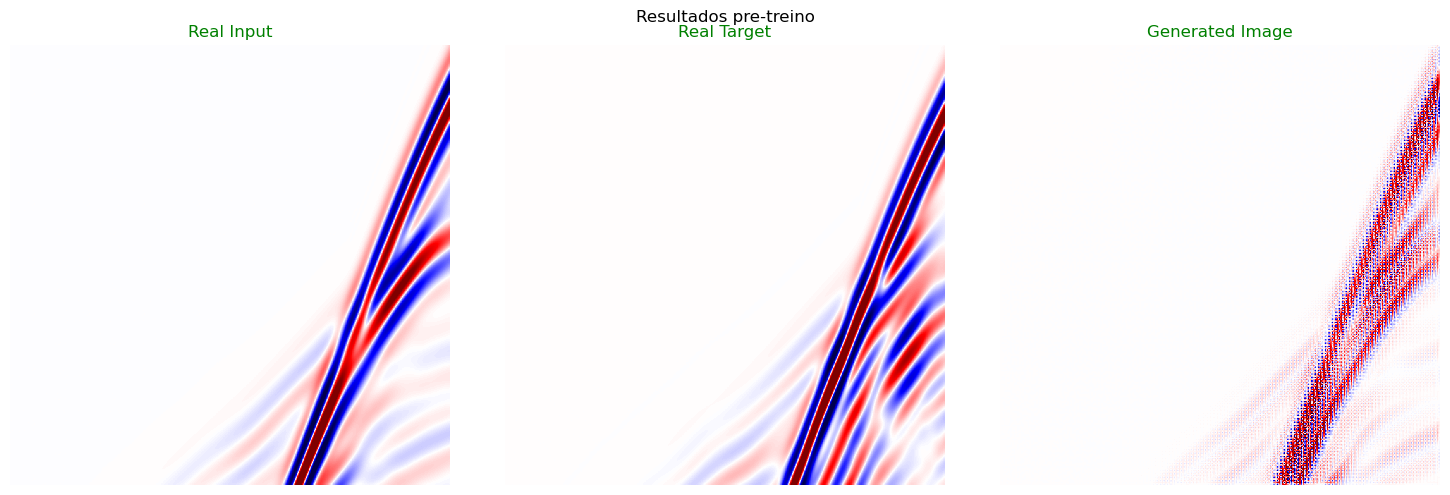

In [18]:
visualize_data(G, D, train_dl, 'Resultados pre-treino', device)

In [19]:
lr_G = 2e-4
lr_D = 2e-4
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(b1, b2))

In [20]:
n_epoches = 120
G_losses, D_losses, L1_losses, GAN_losses = [], [], [], []

for epoch in range(n_epoches):

    G.train()
    D.train()
    LAMBDA = 100

    for i, (input, target) in enumerate(tqdm(train_dl)):
        it = i+1
        input, target = input.to(device), target.to(device)

        real_label = torch.ones_like(D(input, target), device=device)  # Rótulo para imagens reais
        fake_label = torch.zeros_like(D(input, target), device=device) 
        
        fake_image = G(input)
        fake_image_ = fake_image.detach()

        """Train Generators"""
        # set to training mode in the begining, because sample_images will set it to eval mode

        optimizer_G.zero_grad()

        # GAN loss, train G to make D think it's true
        loss_L1 = criterion_L1(fake_image, target)
        loss_GAN = criterion_GAN(D(input, fake_image), real_label) 
        # Não pode usar o fake_image_ aqui, pois o gerador precisa calcular o gradiente com base na imagem fake
        
        # G total loss
        loss_G = loss_GAN + LAMBDA * loss_L1 

        loss_G.backward()
        optimizer_G.step()

        #if it % 2 == 0:
            
        """Train Discriminator """
        optimizer_D.zero_grad()
        
        loss_real = criterion_GAN(D(input, target), real_label)
        loss_fake = criterion_GAN(D(input, fake_image_), fake_label)
        loss_D = (loss_real + loss_fake) * 0.5
        
        loss_D.backward()
        optimizer_D.step()

    # Salvar as perdas para cada época
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    GAN_losses.append(loss_GAN.item())
    L1_losses.append(loss_L1.item())

    print(f'[Epoch {epoch + 1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | GAN: {loss_GAN.item()} L1: {loss_L1.item()}]')
    print(f'[D loss: {loss_D.item()}]')

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 1/120]
[G loss: 3.5057132244110107 | GAN: 0.5970332026481628 L1: 0.029086798429489136]
[D loss: 0.8583354949951172]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 2/120]
[G loss: 7.933074951171875 | GAN: 4.5779242515563965 L1: 0.03355151042342186]
[D loss: 0.09538938850164413]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.19it/s]


[Epoch 3/120]
[G loss: 5.927042007446289 | GAN: 2.7404510974884033 L1: 0.031865909695625305]
[D loss: 0.1280207484960556]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.06it/s]


[Epoch 4/120]
[G loss: 4.559027671813965 | GAN: 3.140791177749634 L1: 0.014182362705469131]
[D loss: 0.05636242777109146]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.06it/s]


[Epoch 5/120]
[G loss: 9.55605697631836 | GAN: 5.841495513916016 L1: 0.037145618349313736]
[D loss: 0.009931854903697968]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 6/120]
[G loss: 4.219549179077148 | GAN: 2.7087507247924805 L1: 0.015107986517250538]
[D loss: 0.14375454187393188]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 7/120]
[G loss: 5.254092216491699 | GAN: 4.091701984405518 L1: 0.011623900383710861]
[D loss: 1.8337877988815308]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 8/120]
[G loss: 5.845523834228516 | GAN: 4.3982439041137695 L1: 0.014472797513008118]
[D loss: 0.01657889038324356]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 9/120]
[G loss: 5.567286491394043 | GAN: 3.471775531768799 L1: 0.02095510996878147]
[D loss: 0.02455873228609562]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.08it/s]


[Epoch 10/120]
[G loss: 5.013091564178467 | GAN: 3.074321985244751 L1: 0.01938769593834877]
[D loss: 2.173381805419922]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.21it/s]


[Epoch 11/120]
[G loss: 8.523425102233887 | GAN: 6.03053092956543 L1: 0.02492893859744072]
[D loss: 0.0027560631278902292]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 12/120]
[G loss: 5.87795352935791 | GAN: 4.502209186553955 L1: 0.013757443986833096]
[D loss: 0.02180762216448784]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.04it/s]


[Epoch 13/120]
[G loss: 10.890294075012207 | GAN: 8.343671798706055 L1: 0.025466226041316986]
[D loss: 0.0011645491467788815]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.00it/s]


[Epoch 14/120]
[G loss: 4.425805568695068 | GAN: 1.9979636669158936 L1: 0.024278419092297554]
[D loss: 0.6579371690750122]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 15/120]
[G loss: 8.047626495361328 | GAN: 6.0175628662109375 L1: 0.02030063048005104]
[D loss: 0.005482290871441364]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 16/120]
[G loss: 4.942591190338135 | GAN: 3.1433615684509277 L1: 0.0179922953248024]
[D loss: 0.09011343866586685]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 17/120]
[G loss: 11.239476203918457 | GAN: 8.668850898742676 L1: 0.025706252083182335]
[D loss: 0.0033067238982766867]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 18/120]
[G loss: 1.5594688653945923 | GAN: 0.4260610044002533 L1: 0.011334078386425972]
[D loss: 1.649078369140625]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.06it/s]


[Epoch 19/120]
[G loss: 1.7551288604736328 | GAN: 1.166322946548462 L1: 0.005888058803975582]
[D loss: 0.7534031271934509]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 20/120]
[G loss: 4.2328596115112305 | GAN: 3.0390853881835938 L1: 0.011937744915485382]
[D loss: 0.10313627123832703]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 21/120]
[G loss: 9.340206146240234 | GAN: 8.190500259399414 L1: 0.01149706169962883]
[D loss: 0.0017578883562237024]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 22/120]
[G loss: 6.903303623199463 | GAN: 5.112541198730469 L1: 0.017907623201608658]
[D loss: 0.005213018506765366]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 23/120]
[G loss: 11.678275108337402 | GAN: 7.751278877258301 L1: 0.039269961416721344]
[D loss: 0.0006097967852838337]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 24/120]
[G loss: 8.596153259277344 | GAN: 6.44648551940918 L1: 0.02149667590856552]
[D loss: 0.002223653718829155]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.15it/s]


[Epoch 25/120]
[G loss: 9.54151439666748 | GAN: 6.993671894073486 L1: 0.025478428229689598]
[D loss: 0.004785872995853424]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 26/120]
[G loss: 9.02466106414795 | GAN: 6.581692695617676 L1: 0.02442968264222145]
[D loss: 0.002426751423627138]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.09it/s]


[Epoch 27/120]
[G loss: 6.011498928070068 | GAN: 4.500304222106934 L1: 0.015111945569515228]
[D loss: 0.012830134481191635]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.08it/s]


[Epoch 28/120]
[G loss: 9.121620178222656 | GAN: 7.021900653839111 L1: 0.020997190847992897]
[D loss: 0.0022637848742306232]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.16it/s]


[Epoch 29/120]
[G loss: 9.885351181030273 | GAN: 7.952678203582764 L1: 0.019326727837324142]
[D loss: 0.0013503634836524725]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 30/120]
[G loss: 12.798675537109375 | GAN: 11.413569450378418 L1: 0.01385105587542057]
[D loss: 0.00023479647643398494]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.10it/s]


[Epoch 31/120]
[G loss: 8.029155731201172 | GAN: 6.058662414550781 L1: 0.01970493793487549]
[D loss: 0.00232065306045115]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.02it/s]


[Epoch 32/120]
[G loss: 12.35080337524414 | GAN: 9.24242877960205 L1: 0.031083740293979645]
[D loss: 0.0014382379595190287]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 33/120]
[G loss: 12.34567642211914 | GAN: 9.018965721130371 L1: 0.033267103135585785]
[D loss: 0.000239976478042081]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.19it/s]


[Epoch 34/120]
[G loss: 12.834118843078613 | GAN: 10.446717262268066 L1: 0.023874014616012573]
[D loss: 5.569598215515725e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.17it/s]


[Epoch 35/120]
[G loss: 12.91955852508545 | GAN: 9.815773010253906 L1: 0.03103785589337349]
[D loss: 0.00015041237929835916]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.15it/s]


[Epoch 36/120]
[G loss: 10.376849174499512 | GAN: 7.892018795013428 L1: 0.024848300963640213]
[D loss: 0.0013262361753731966]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 12.97it/s]


[Epoch 37/120]
[G loss: 8.610599517822266 | GAN: 6.859380722045898 L1: 0.017512189224362373]
[D loss: 0.014536942355334759]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 12.97it/s]


[Epoch 38/120]
[G loss: 12.283748626708984 | GAN: 9.368077278137207 L1: 0.02915671281516552]
[D loss: 0.0007754768594168127]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 39/120]
[G loss: 14.02283763885498 | GAN: 12.039652824401855 L1: 0.01983184553682804]
[D loss: 9.950701496563852e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 40/120]
[G loss: 11.205266952514648 | GAN: 9.147838592529297 L1: 0.020574279129505157]
[D loss: 0.0007591882022097707]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 41/120]
[G loss: 10.079483032226562 | GAN: 8.01763916015625 L1: 0.020618436858057976]
[D loss: 0.0004990235902369022]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 42/120]
[G loss: 11.269463539123535 | GAN: 9.41148567199707 L1: 0.01857977733016014]
[D loss: 0.0002849248412530869]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 43/120]
[G loss: 5.531534671783447 | GAN: 4.246747970581055 L1: 0.012847868725657463]
[D loss: 0.016475476324558258]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 44/120]
[G loss: 9.680185317993164 | GAN: 8.020432472229004 L1: 0.016597524285316467]
[D loss: 0.00048646051436662674]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.15it/s]


[Epoch 45/120]
[G loss: 12.56596565246582 | GAN: 9.552998542785645 L1: 0.030129674822092056]
[D loss: 0.0003520349273458123]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.09it/s]


[Epoch 46/120]
[G loss: 14.603681564331055 | GAN: 12.555849075317383 L1: 0.020478323101997375]
[D loss: 0.0001343736657872796]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.08it/s]


[Epoch 47/120]
[G loss: 11.962852478027344 | GAN: 9.930106163024902 L1: 0.02032746560871601]
[D loss: 0.0005705241928808391]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 48/120]
[G loss: 11.895953178405762 | GAN: 9.436243057250977 L1: 0.024597100913524628]
[D loss: 0.0008238449227064848]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 49/120]
[G loss: 7.266057014465332 | GAN: 6.031307697296143 L1: 0.012347493320703506]
[D loss: 0.005969236604869366]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 50/120]
[G loss: 10.429350852966309 | GAN: 9.659616470336914 L1: 0.007697342894971371]
[D loss: 0.0004768904182128608]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 51/120]
[G loss: 11.096834182739258 | GAN: 9.486498832702637 L1: 0.0161033533513546]
[D loss: 0.00026262528263032436]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 52/120]
[G loss: 11.667957305908203 | GAN: 8.640344619750977 L1: 0.03027612343430519]
[D loss: 0.000216364162042737]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 53/120]
[G loss: 4.526484489440918 | GAN: 2.0449023246765137 L1: 0.024815820157527924]
[D loss: 0.14796200394630432]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 54/120]
[G loss: 11.59451961517334 | GAN: 9.304731369018555 L1: 0.022897880524396896]
[D loss: 0.0004470807616598904]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.47it/s]


[Epoch 55/120]
[G loss: 13.03175163269043 | GAN: 10.971723556518555 L1: 0.02060028538107872]
[D loss: 0.0011185113107785583]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 56/120]
[G loss: 9.476704597473145 | GAN: 7.7559685707092285 L1: 0.01720736175775528]
[D loss: 0.000543520669452846]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 57/120]
[G loss: 5.797607898712158 | GAN: 4.076427936553955 L1: 0.017211800441145897]
[D loss: 0.017237843945622444]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 58/120]
[G loss: 11.747029304504395 | GAN: 9.328266143798828 L1: 0.024187631905078888]
[D loss: 0.0023414313327521086]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 59/120]
[G loss: 6.03803014755249 | GAN: 4.21480131149292 L1: 0.01823228783905506]
[D loss: 0.029244594275951385]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 60/120]
[G loss: 10.79854965209961 | GAN: 8.986801147460938 L1: 0.018117481842637062]
[D loss: 0.0003243846877012402]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 61/120]
[G loss: 11.854623794555664 | GAN: 9.815402030944824 L1: 0.02039221301674843]
[D loss: 0.00016656848310958594]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 62/120]
[G loss: 9.390604019165039 | GAN: 8.5316743850708 L1: 0.008589296601712704]
[D loss: 0.0003202887892257422]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 63/120]
[G loss: 12.176145553588867 | GAN: 9.50737476348877 L1: 0.026687713339924812]
[D loss: 0.00025772990193217993]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 64/120]
[G loss: 11.811742782592773 | GAN: 10.391660690307617 L1: 0.014200815930962563]
[D loss: 0.0001170874311355874]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 65/120]
[G loss: 7.989497184753418 | GAN: 6.531783103942871 L1: 0.014577142894268036]
[D loss: 0.0022505440283566713]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 66/120]
[G loss: 7.899570465087891 | GAN: 6.357428073883057 L1: 0.015421422198414803]
[D loss: 0.0017602626467123628]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 67/120]
[G loss: 12.43916130065918 | GAN: 10.209856033325195 L1: 0.022293057292699814]
[D loss: 0.00034652030444703996]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 68/120]
[G loss: 9.59037971496582 | GAN: 8.917542457580566 L1: 0.006728374864906073]
[D loss: 0.00037768451147712767]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 69/120]
[G loss: 11.484253883361816 | GAN: 8.749013900756836 L1: 0.02735239826142788]
[D loss: 0.0014520949916914105]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 70/120]
[G loss: 9.962705612182617 | GAN: 8.619927406311035 L1: 0.013427785597741604]
[D loss: 0.0007485031383112073]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 71/120]
[G loss: 7.876081943511963 | GAN: 6.486708164215088 L1: 0.013893736526370049]
[D loss: 0.001710516749881208]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 72/120]
[G loss: 12.787727355957031 | GAN: 10.845907211303711 L1: 0.019418198615312576]
[D loss: 0.00015207481919787824]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 73/120]
[G loss: 7.589326858520508 | GAN: 6.628482341766357 L1: 0.009608443826436996]
[D loss: 0.0019185954006388783]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 74/120]
[G loss: 10.431870460510254 | GAN: 9.658072471618652 L1: 0.007737982086837292]
[D loss: 0.00029542308766394854]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 75/120]
[G loss: 6.078427791595459 | GAN: 5.580932140350342 L1: 0.0049749575555324554]
[D loss: 0.0035345780197530985]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 76/120]
[G loss: 11.405872344970703 | GAN: 8.917767524719238 L1: 0.024881044402718544]
[D loss: 0.0005501765990629792]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 77/120]
[G loss: 4.232109546661377 | GAN: 1.8571885824203491 L1: 0.02374921180307865]
[D loss: 0.13881225883960724]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 78/120]
[G loss: 7.310088634490967 | GAN: 6.5782904624938965 L1: 0.0073179816827178]
[D loss: 0.0035524601116776466]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 79/120]
[G loss: 11.372467994689941 | GAN: 8.294129371643066 L1: 0.030783386901021004]
[D loss: 0.016229601576924324]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 80/120]
[G loss: 10.356063842773438 | GAN: 8.328014373779297 L1: 0.020280499011278152]
[D loss: 0.000536046689376235]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 81/120]
[G loss: 8.086424827575684 | GAN: 7.037517547607422 L1: 0.010489068925380707]
[D loss: 0.0008152950322255492]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 82/120]
[G loss: 13.13297176361084 | GAN: 11.194327354431152 L1: 0.019386446103453636]
[D loss: 8.075932419160381e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 83/120]
[G loss: 2.3091282844543457 | GAN: 0.4448930323123932 L1: 0.018642352893948555]
[D loss: 0.8328253626823425]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 84/120]
[G loss: 12.49186897277832 | GAN: 11.248422622680664 L1: 0.012434465810656548]
[D loss: 0.00012675773177761585]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 85/120]
[G loss: 2.6227593421936035 | GAN: 1.6460790634155273 L1: 0.009766803123056889]
[D loss: 0.20701226592063904]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 86/120]
[G loss: 10.706502914428711 | GAN: 8.576208114624023 L1: 0.021302945911884308]
[D loss: 0.002281416207551956]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 87/120]
[G loss: 13.29505729675293 | GAN: 10.658806800842285 L1: 0.026362501084804535]
[D loss: 0.0004715039976872504]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 88/120]
[G loss: 13.036112785339355 | GAN: 11.394586563110352 L1: 0.01641526073217392]
[D loss: 4.646346133085899e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 89/120]
[G loss: 10.371517181396484 | GAN: 7.8378777503967285 L1: 0.02533639222383499]
[D loss: 0.0012237157206982374]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 90/120]
[G loss: 9.321642875671387 | GAN: 9.057496070861816 L1: 0.0026414659805595875]
[D loss: 0.000822993868496269]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 91/120]
[G loss: 10.445711135864258 | GAN: 7.593298435211182 L1: 0.028524121269583702]
[D loss: 0.0006481221062131226]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 92/120]
[G loss: 8.811657905578613 | GAN: 8.025012969970703 L1: 0.007866445928812027]
[D loss: 0.0008206423954106867]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 93/120]
[G loss: 13.604141235351562 | GAN: 11.979935646057129 L1: 0.016242053359746933]
[D loss: 9.47330190683715e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 94/120]
[G loss: 6.311883926391602 | GAN: 4.76058292388916 L1: 0.015513011254370213]
[D loss: 0.8870581388473511]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 95/120]
[G loss: 11.270787239074707 | GAN: 10.701690673828125 L1: 0.005690965801477432]
[D loss: 0.02442794106900692]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 96/120]
[G loss: 12.638753890991211 | GAN: 10.282214164733887 L1: 0.023565392941236496]
[D loss: 0.00020598545961547643]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 97/120]
[G loss: 13.052013397216797 | GAN: 11.685450553894043 L1: 0.013665633276104927]
[D loss: 0.0006848242483101785]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 98/120]
[G loss: 8.011703491210938 | GAN: 7.21029806137085 L1: 0.00801405031234026]
[D loss: 0.0008207065402530134]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 99/120]
[G loss: 7.860662937164307 | GAN: 6.992783546447754 L1: 0.008678795769810677]
[D loss: 0.0009097887086682022]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 100/120]
[G loss: 8.362115859985352 | GAN: 6.928928852081299 L1: 0.01433186698704958]
[D loss: 0.013663958758115768]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 101/120]
[G loss: 9.800007820129395 | GAN: 8.68095874786377 L1: 0.011190487071871758]
[D loss: 0.0006678137579001486]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 102/120]
[G loss: 5.500505447387695 | GAN: 3.5874111652374268 L1: 0.019130945205688477]
[D loss: 0.0227411650121212]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 103/120]
[G loss: 14.362903594970703 | GAN: 11.962382316589355 L1: 0.024005208164453506]
[D loss: 0.0007353874389082193]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 104/120]
[G loss: 12.081770896911621 | GAN: 9.115436553955078 L1: 0.029663344845175743]
[D loss: 0.0004267686163075268]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 105/120]
[G loss: 10.867927551269531 | GAN: 9.628548622131348 L1: 0.012393789365887642]
[D loss: 0.0002547218755353242]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 106/120]
[G loss: 12.343326568603516 | GAN: 9.173173904418945 L1: 0.03170153126120567]
[D loss: 0.00020138749096076936]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 107/120]
[G loss: 7.743721961975098 | GAN: 6.086919784545898 L1: 0.016568023711442947]
[D loss: 0.0030338820070028305]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 108/120]
[G loss: 3.387512445449829 | GAN: 2.140805721282959 L1: 0.012467066757380962]
[D loss: 0.08347196131944656]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 109/120]
[G loss: 12.208698272705078 | GAN: 10.206673622131348 L1: 0.020020250231027603]
[D loss: 0.00024841056438162923]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 110/120]
[G loss: 8.300272941589355 | GAN: 6.617990970611572 L1: 0.016822822391986847]
[D loss: 0.11220274865627289]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 111/120]
[G loss: 16.01962661743164 | GAN: 13.894051551818848 L1: 0.021255740895867348]
[D loss: 0.0005025481805205345]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 112/120]
[G loss: 8.196444511413574 | GAN: 5.800559043884277 L1: 0.023958854377269745]
[D loss: 1.1724060773849487]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 113/120]
[G loss: 7.658210754394531 | GAN: 6.375101089477539 L1: 0.012831099331378937]
[D loss: 0.0014118640683591366]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 114/120]
[G loss: 7.995474338531494 | GAN: 6.5161566734313965 L1: 0.014793175272643566]
[D loss: 0.0017906102584674954]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 115/120]
[G loss: 8.430895805358887 | GAN: 6.1088666915893555 L1: 0.02322029136121273]
[D loss: 0.0033138636499643326]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 116/120]
[G loss: 8.465567588806152 | GAN: 7.602470874786377 L1: 0.008630963042378426]
[D loss: 0.0008414832409471273]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 117/120]
[G loss: 13.129788398742676 | GAN: 11.544795036315918 L1: 0.01584993302822113]
[D loss: 0.004562762100249529]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 118/120]
[G loss: 12.463614463806152 | GAN: 11.453051567077637 L1: 0.01010563038289547]
[D loss: 0.003071886021643877]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 119/120]
[G loss: 9.864173889160156 | GAN: 7.571294784545898 L1: 0.022928792983293533]
[D loss: 0.0008572989609092474]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]

[Epoch 120/120]
[G loss: 6.024204730987549 | GAN: 5.143557071685791 L1: 0.008806477300822735]
[D loss: 0.005995897576212883]


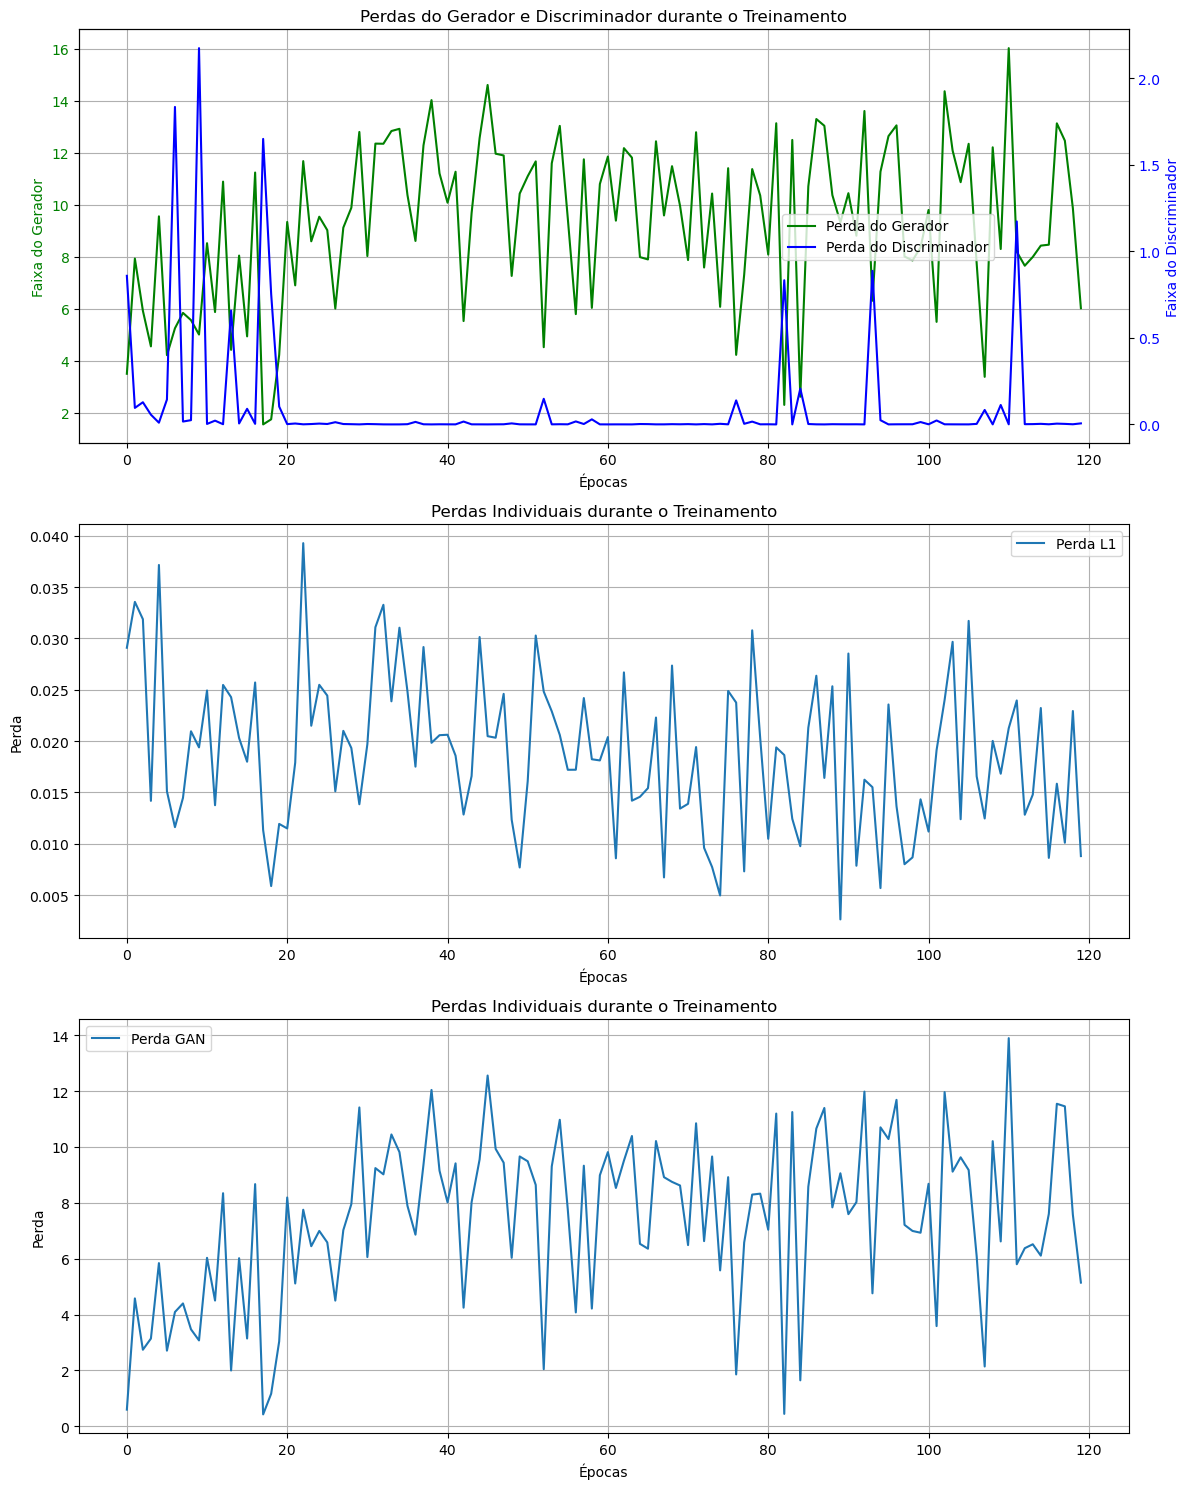

In [21]:
fig, (ax1, ax3, ax4) = plt.subplots(3,1, figsize=(12, 15))  # Definindo um layout de 1 linha e 2 colunas

# Primeiro gráfico: Perdas do Gerador e Discriminador
ax1.plot(G_losses, 'g-', label="Perda do Gerador")
ax1.set_xlabel("Épocas")
ax1.set_ylabel('Faixa do Gerador', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2 = ax1.twinx()
ax2.plot(D_losses, 'b-', label="Perda do Discriminador")
ax2.set_ylabel('Faixa do Discriminador', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perdas do Gerador e Discriminador durante o Treinamento")
ax1.grid()
fig.legend(loc='upper left',  bbox_to_anchor=(0.65, 0.858))

# Segundo gráfico: Perdas Individuais durante o Treinamento
ax3.plot(L1_losses, label="Perda L1")
ax3.set_xlabel("Épocas")
ax3.set_ylabel("Perda")
ax3.set_title("Perdas Individuais durante o Treinamento")
ax3.grid()
ax3.legend()

ax4.plot(GAN_losses, label="Perda GAN")
ax4.set_xlabel("Épocas")
ax4.set_ylabel("Perda")
ax4.set_title("Perdas Individuais durante o Treinamento")
ax4.grid()
ax4.legend()

# Salvando os gráficos
plt.tight_layout()  # Ajusta automaticamente o espaçamento
plt.savefig('pix2pix_P2VX_Loss_V2.png')
plt.show()

In [22]:
torch.save({
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'generator_optimizer_state_dict': optimizer_G.state_dict(),
    'discriminator_optimizer_state_dict': optimizer_D.state_dict(),
    'epoch': epoch
}, 'pix2pix_P2VXcheckpoint_V1.pth')

checkpoint = torch.load('pix2pix_P2VXcheckpoint_V2.pth', weights_only=True)